In [1]:
import os, sys, time

from tqdm.notebook import tqdm
import pandas as pd
import json
import numpy as np
from collections import defaultdict
from scipy import stats
from datasets import load_from_disk
from transformers import ViTForImageClassification
from utils.helper import get_device
from utils.vit_util import transforms, transforms_c100
from utils.constant import ViTExperiment
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
import torch
device = get_device()

2025-04-21 22:19:47.831487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-21 22:19:47.914169: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 22:19:48.504187: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-04-21 22:19:48.504246: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

Device: cuda


In [2]:
ds_name = "c100"
k = 0
# pretrained modelのロード
pretrained_dir = getattr(ViTExperiment, ds_name).OUTPUT_DIR.format(k=k)
model = ViTForImageClassification.from_pretrained(pretrained_dir).to(device)
model.eval()
# 対象の設定
start_li = 0
target_li = -1
end_li = model.vit.config.num_hidden_layers

# datasetごとに違う変数のセット
if ds_name == "c10":
    tf_func = transforms
    label_col = "label"
    num_labels = 10
elif ds_name == "c100":
    tf_func = transforms_c100
    label_col = "fine_label"
    num_labels = 100
else:
    NotImplementedError

vscore_dir = os.path.join(pretrained_dir, "vscores")
target_split_names = ["train", "repair"]

split: train
vscores shape (cor): (3072, 12)
vscores shape (mis): (3072, 12)
sum(condition)=308


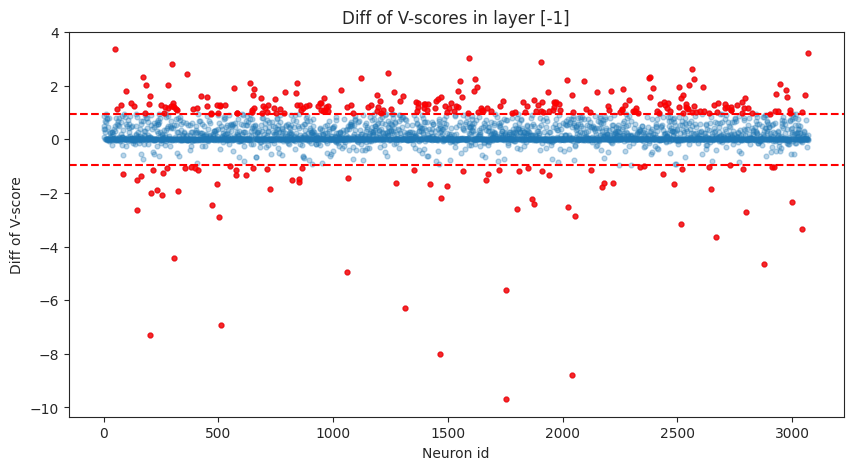

cosine_similarity=[0.99087993 0.98393203 0.99392716 0.98832884 0.98282169 0.98640087
 0.96388586 0.98798119 0.98575381 0.98046927 0.77584439 0.8276859 ]


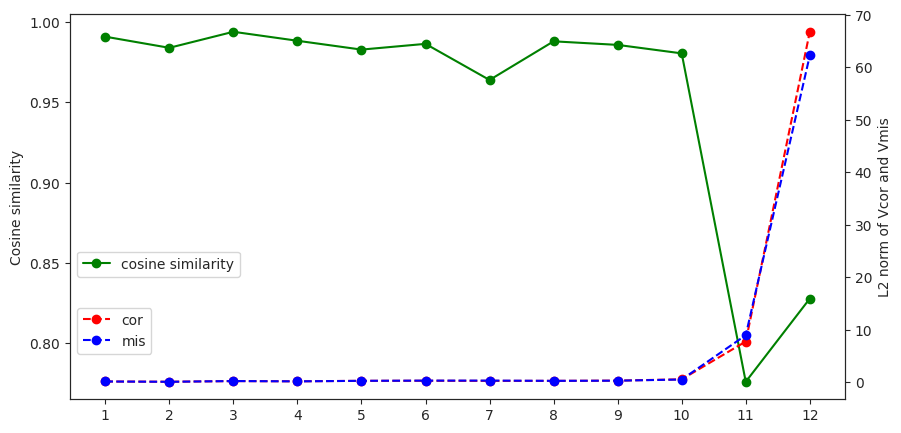

split: repair
vscores shape (cor): (3072, 12)
vscores shape (mis): (3072, 12)
sum(condition)=308


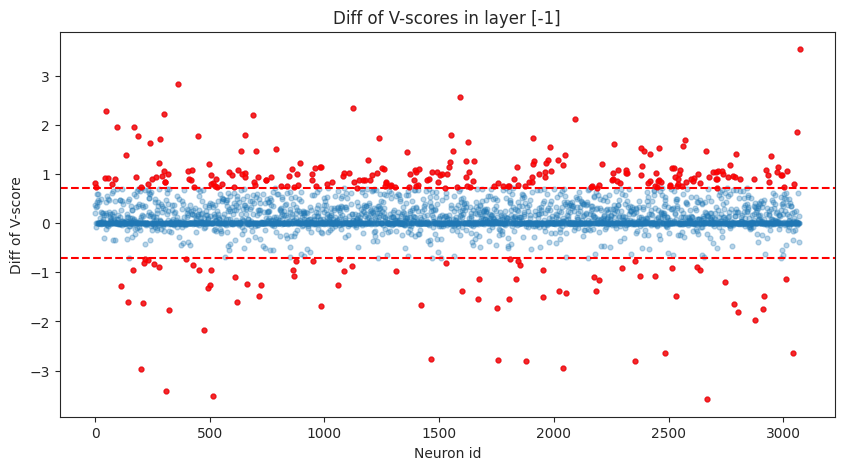

cosine_similarity=[0.97397784 0.98954648 0.99579993 0.99427609 0.98896463 0.99445116
 0.99031253 0.99580739 0.99415132 0.99041052 0.89323452 0.9226144 ]


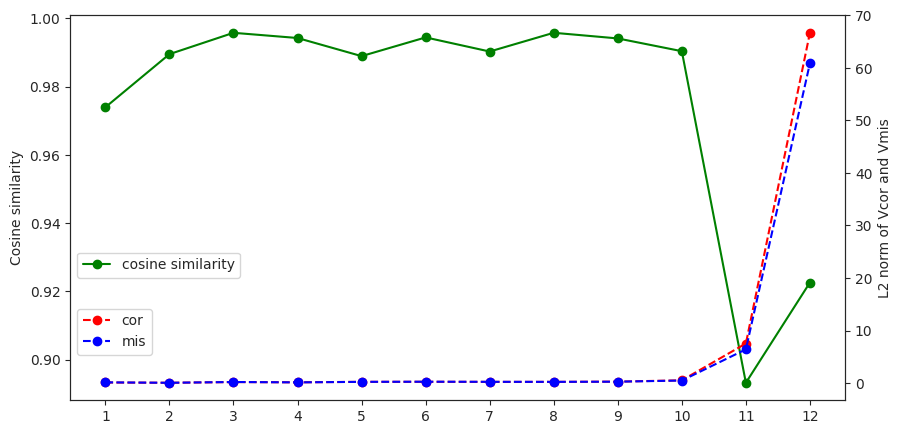

In [3]:
vmap_dic = defaultdict(defaultdict)

for split in target_split_names:
    print(f"split: {split}")
    vmap_dic[split] = defaultdict(defaultdict)
    # 正解と不正解時のvscoreを読み込む
    for cor_mis in ["cor", "mis"]:
        vmap_dic[split][cor_mis] = defaultdict(np.array)
        ds_type = f"ori_{split}"
        vscore_save_path = os.path.join(vscore_dir, f"vscore_l1tol{end_li}_all_label_{ds_type}_{cor_mis}.npy")
        vscores = np.load(vscore_save_path)
        vmap_dic[split][cor_mis] = vscores.T
        print(f"vscores shape ({cor_mis}): {vmap_dic[split][cor_mis].shape}")
    # vscoresのcorとmisの差分をヒートマップで可視化
    layers4show = [-1]
    x_axis_size = len(layers4show)
    vmap_cor = vmap_dic[split]["cor"]
    vmap_mis = vmap_dic[split]["mis"]
    vmap_diff = vmap_cor - vmap_mis
    # 横軸をニューロン，縦軸をスコアとした折れ線グラフ
    plt.figure(figsize=(10, 5))
    # vmap[:, layers4show] の絶対値の上位10%だけマーカーの色を赤に変える
    top10 = np.percentile(np.abs(vmap_diff[:, layers4show]), 90)
    condition = np.abs(vmap_diff[:, layers4show]).reshape(-1) > top10
    print(f"sum(condition)={sum(condition)}")
    # top10の値に横線を引く
    plt.axhline(y=top10, color="red", linestyle="--")
    plt.axhline(y=-top10, color="red", linestyle="--")
    plt.scatter(np.array(range(len(vmap_diff[:, layers4show]))), vmap_diff[:, layers4show], alpha=0.3, s=12)
    plt.scatter(np.array(range(len(vmap_diff[:, layers4show])))[condition], vmap_diff[:, layers4show][condition], alpha=0.8, s=12, color="red")
    plt.xlabel("Neuron id")
    plt.ylabel("Diff of V-score")
    plt.title(f"Diff of V-scores in layer {layers4show}")
    plt.show()
    # vmap_dic[used_column][tgt_ct]["cor"] と vmap_dic[used_column][tgt_ct]["mis"] の，行ごとの内積を取る
    dot_products = np.sum(vmap_cor * vmap_mis, axis=0)
    a_norms = np.linalg.norm(vmap_cor, axis=0)
    b_norms = np.linalg.norm(vmap_mis, axis=0)
    cosine_similarity = dot_products / (a_norms * b_norms)
    print(f"cosine_similarity={cosine_similarity}") # corとmisのcos類似度
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(cosine_similarity, color="g", marker="o", label="cosine similarity")
    ax1.set_ylabel('Cosine similarity')
    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    ax2.plot(a_norms, color="r", marker="o", linestyle="--", label="cor")
    ax2.plot(b_norms, color="b", marker="o", linestyle="--", label="mis")
    ax2.set_xlabel("Layer")
    ax2.set_ylabel("L2 norm of Vcor and Vmis")
    # グラフに凡例を追加
    ax1.legend(loc='lower left', bbox_to_anchor=(0, 0.3))
    ax2.legend(loc='lower left', bbox_to_anchor=(0, 0.1))
    plt.xticks(np.arange(0, end_li-start_li, 1), np.arange(start_li+1, end_li+1, 1))
    plt.show()